In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np 
import xarray as xr 
import netCDF4

In [3]:
## Function to Compute Earth-Relative Winds

def earth_relative_wind_components(ugrd, vgrd):
    if 'crs' not in list(ugrd.coords):
        raise ValueError('No CRS in coordinate, be sure to use the MetPy accessor parse_cf()')

    data_crs = ugrd.metpy.cartopy_crs

    x = ugrd.x.values
    y = ugrd.y.values

    xx, yy = np.meshgrid(x, y)

    ut, vt = ccrs.PlateCarree().transform_vectors(data_crs, xx, yy, ugrd.values, vgrd.values)

    uer = ut * units(ugrd.units)
    ver = vt * units(vgrd.units)

    return uer, ver

In [4]:
## Open Data Set


ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/casestudies/'
                     'python-gallery/NAM_20161031_1200.nc').metpy.parse_cf()

In [5]:
#Retrieving the Data

lats = ds.lat.data
lons = ds.lon.data

x = ds['u-component_of_wind_isobaric'].x
y = ds['u-component_of_wind_isobaric'].y

xx, yy = np.meshgrid(x, y)

datacrs = ds['u-component_of_wind_isobaric'].metpy.cartopy_crs

level = 500 * units.hPa 
hght_500 = mpcalc.smooth_n_point(ds.Geopotential_height_isobaric.metpy.sel(vertical=level).squeeze(), 9, 50)

uwnd_500 = ds['u-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze()
vwnd_500 = ds['v-component_of_wind_isobaric'].metpy.sel(vertical=level).squeeze()

uwnd_er, vwnd_er = earth_relative_wind_components(uwnd_500, vwnd_500)

uwnd_er = mpcalc.smooth_n_point(uwnd_er, 9, 50)
vwnd_er = mpcalc.smooth_n_point(vwnd_er, 9, 50)

vtime = ds.time.data[0].astype('datetime64[ms]').astype('O')

In [6]:
#MetPy Absolute Vorticity Calculation

dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

avor_500 = mpcalc.absolute_vorticity(uwnd_er, vwnd_er, dx, dy, lats * units.degrees, dim_order='yx')

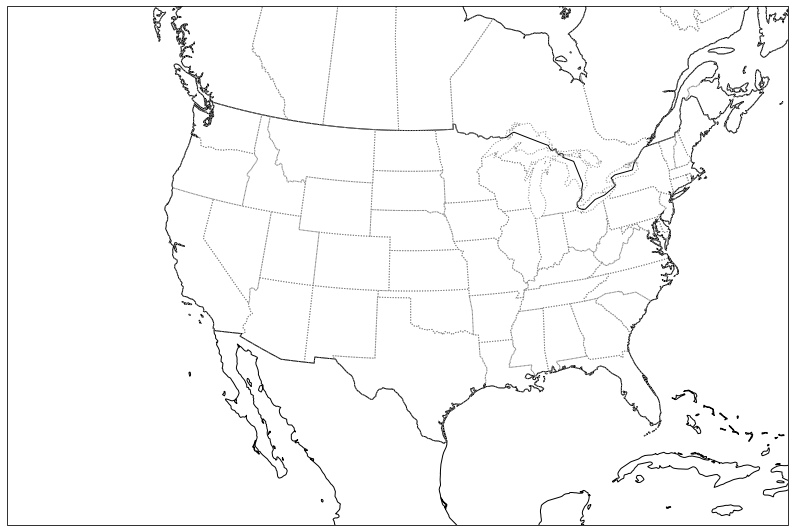

In [19]:
#Creating the Map

mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35, standard_parallels=(30,60))

datacrs = ccrs.PlateCarree()

fig = plt.figure(1, figsize=(14,12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.BORDERS.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle='dotted', edgecolor='grey')


